# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as plt
from tqdm import notebook
from PIL import Image

import scipy.stats as st
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


sb.set(style = 'whitegrid')
sb.set(rc={'figure.figsize':(16,9)})
sb.set_context('paper', rc={'font.size': 10,
                             'axes.titlesize': 10,
                             'xtrick.labelsize': 'small',
                             'ytrick.labelsize': 'small',
                             'legend.fontsize': 'small',
                             'legend.title_fontsize':10})

In [2]:
data_1 = pd.read_csv('/datasets/faces/labels.csv')
data_1.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Text(0, 0.5, 'Кол-во фотографий')

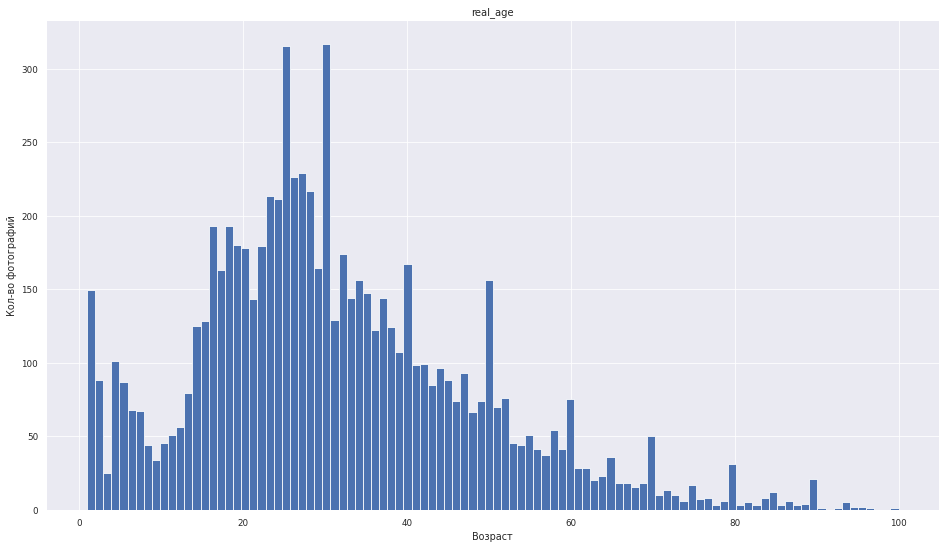

In [3]:
data_1.info()
data_1.hist(bins=100)
plt.xlabel('Возраст',)
plt.ylabel('Кол-во фотографий')

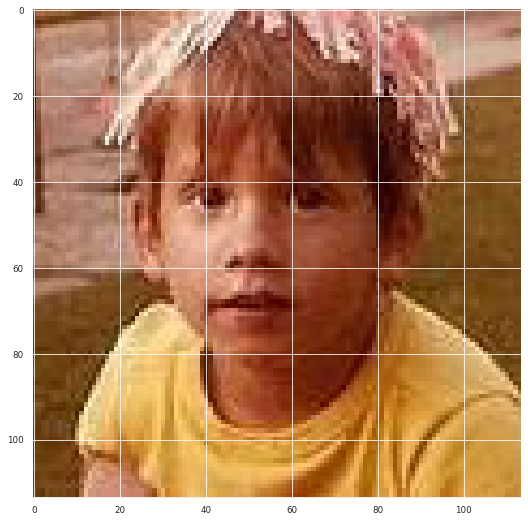

Возраст: 4


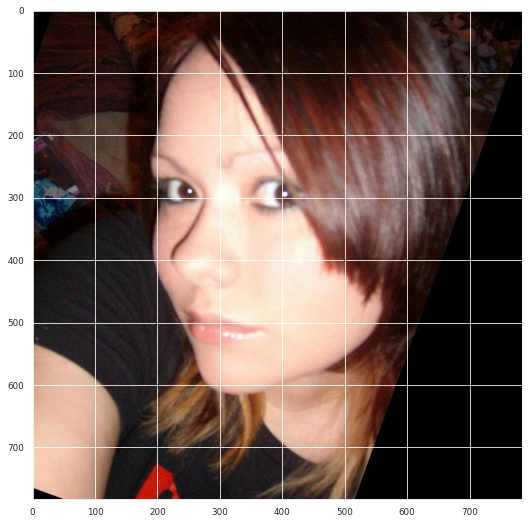

Возраст: 18


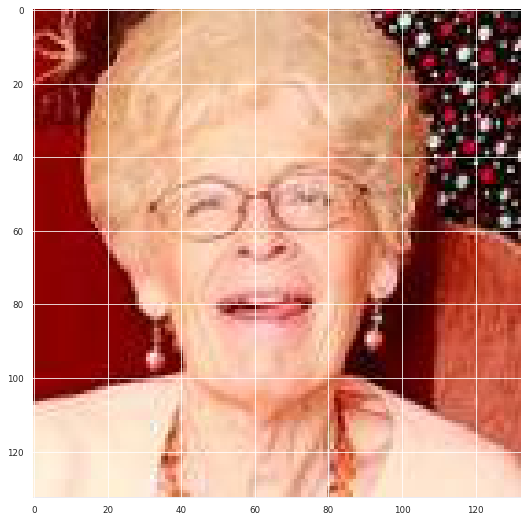

Возраст: 80


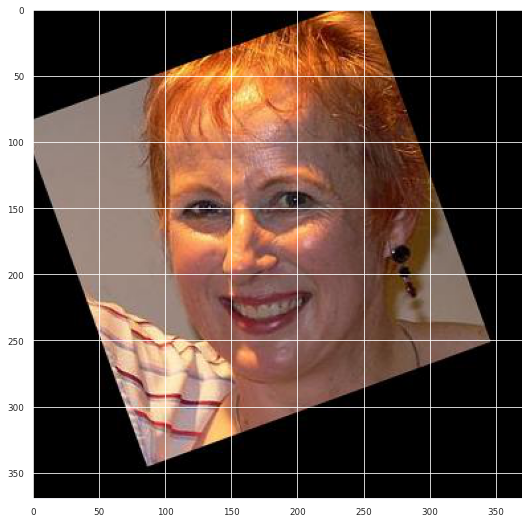

Возраст: 50


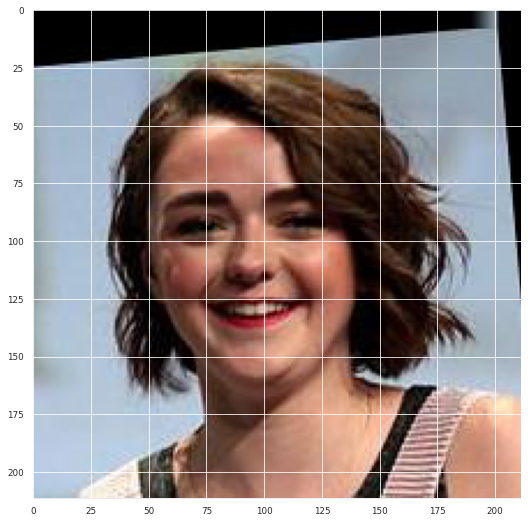

Возраст: 17


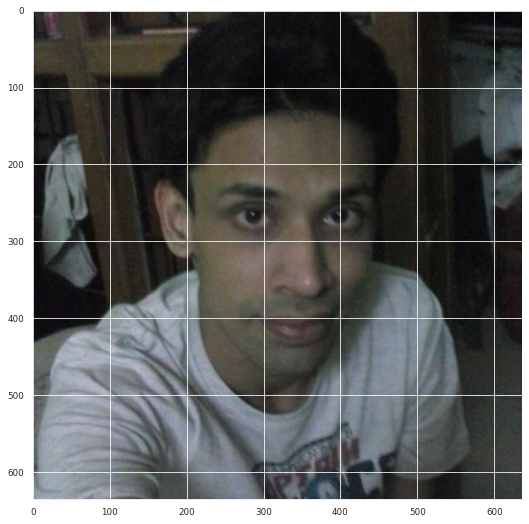

Возраст: 27


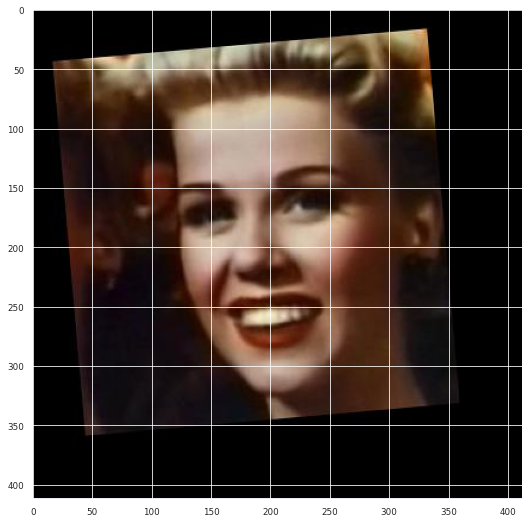

Возраст: 24


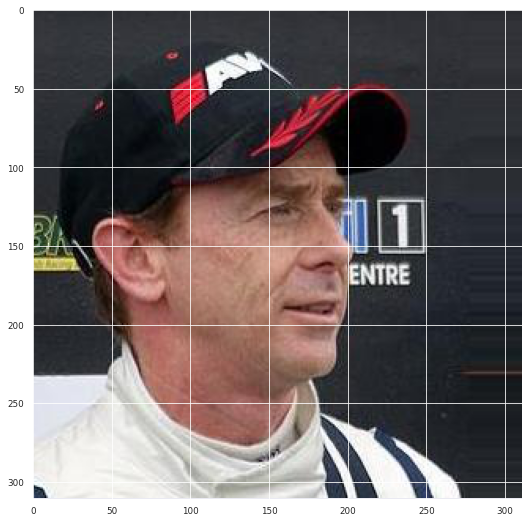

Возраст: 43


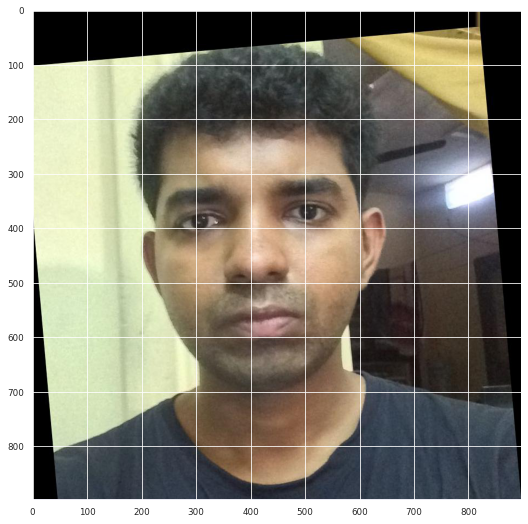

Возраст: 26


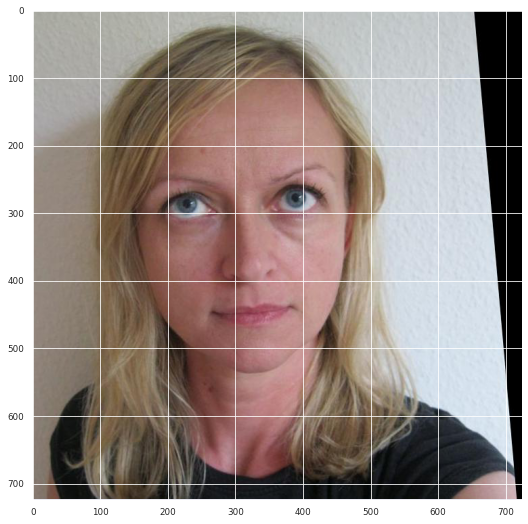

Возраст: 39


In [4]:
for i in range(10):
    image = Image.open('/datasets/faces/final_files/00000'+str(i)+'.jpg')
    plt.imshow(image, cmap='gray')
    plt.show()
    print('Возраст:', data_1.loc[i, 'real_age'])


### Вывод

- В датасете представлено 7591 изображение для обучения и тестирования модели
- Пропусков в значениях нет, данные хорошо структурированы
- По новорожденным данных почти нет, едва ли их нужно учитывать в рамках ТЗ
- Распределение кол-ва фотографий по возрастам не равномерное, у модели могут возникнуть сложности с определение возраста больше 60-ти лет 
- Качество фотографий сильно различается, также есть девушки с макияжем, мужчины в головных уборах - это может усложнить модель

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd


def load_train(path):
    # Загружаем данные из CSV в DataFrame
    labels_df = pd.read_csv(f'{path}/labels.csv')
    
    # Создаем генератор изображений с разделением на обучающую и тестовую выборки
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    # Генерируем обучающую выборку из DataFrame
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',  # Используем "training" для обучающей выборки
        seed=12345
    )

    return train_datagen_flow

def load_test(path):
    # Загружаем данные из CSV в DataFrame
    labels_df = pd.read_csv(f'{path}/labels.csv')
    
    # Создаем генератор изображений с разделением на обучающую и тестовую выборки
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # Генерируем тестовую выборку из DataFrame
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',  # Используем "validation" для тестовой выборки
        seed=12345
    )

    return test_datagen_flow

def create_model(input_shape):
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    ) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])     
    model.summary() 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

    model.fit(
        train_data,
        validation_data=test_data, 
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, 
        shuffle=False
    )
    
    return model

```

```

178/178 - 51s - loss: 810.9160 - mae: 23.2147 - val_loss: 519.4699 - val_mae: 17.5909
Epoch 2/10
178/178 - 40s - loss: 436.2792 - mae: 15.2981 - val_loss: 470.5036 - val_mae: 16.4659
Epoch 3/10
178/178 - 40s - loss: 277.2441 - mae: 11.8156 - val_loss: 313.1295 - val_mae: 13.0907
Epoch 4/10
178/178 - 40s - loss: 199.4524 - mae: 9.9204 - val_loss: 214.7270 - val_mae: 10.7290
Epoch 5/10
178/178 - 40s - loss: 136.9272 - mae: 7.8473 - val_loss: 149.1702 - val_mae: 8.9260
Epoch 6/10
178/178 - 40s - loss: 90.1534 - mae: 6.0441 - val_loss: 152.3716 - val_mae: 8.9214
Epoch 7/10
178/178 - 40s - loss: 64.8821 - mae: 5.0637 - val_loss: 136.9896 - val_mae: 8.5379
Epoch 8/10
178/178 - 40s - loss: 47.8744 - mae: 4.2823 - val_loss: 100.8408 - val_mae: 7.4243
Epoch 9/10
178/178 - 40s - loss: 37.7605 - mae: 3.8214 - val_loss: 85.5895 - val_mae: 6.9189
Epoch 10/10
178/178 - 40s - loss: 32.6794 - mae: 3.7040 - val_loss: 89.2926 - val_mae: 7.5053

```

## Анализ обученной модели

Для обучения была использована архитектура ResNet, чтобы код выполнялся быстрее, были загружены веса модели ResNet50.
Также использовался метод GlobalAveragePooling2D для уменьшения размерности и три дополнительных слоя с активаторами tanh и relu. Для обучения использовалось 15 эпох.

По выводам в процессе обучения видно, что модель с каждой новой эпохой переобучается все сильнее. Не смотря на переобучение метрика на тестовой выборке увеличивается, значит процесс обучения построен корректно. На модели значительно сказался дисбаланс классов. Если дополнить датасет бОльшим количеством фотографий детей и пожилых людей старше 60-ти, то качество модели может значительно улучшиться.

Для оценки качества модели применялась метрика MAE - это средняя величина разницы между предсказанными и реальными значениями целевой переменной. Метрика MAE на тестовой выборке равна 7.5, на тренировочной 3.7